# LAB | Unsupervised Learning

### Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

## Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [2]:
#Create a connection with create_engine to MySQL Workbench:

# Your code here
from urllib.parse import quote_plus
import db_config  

# URL-encode the password
encoded_password = quote_plus(db_config.password)

# create connection string
connection_string = f"mysql+pymysql://{db_config.username}:{encoded_password}@{db_config.host}:{db_config.port}/{db_config.database}"

# create engine
engine = create_engine(connection_string)

# load table into DataFrame
customers= pd.read_sql_table('wholesale_customers_data', con=engine)


## Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:
# Show the first few rows
print(customers.head())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


In [4]:
# Check info
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None


In [5]:
#Check missing values
print(customers.isnull().sum())

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [6]:
# Describe statistics
print(customers.describe())

          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      742.250000        256.750000    408.

In [7]:
# Check for categorical columns
print(customers.select_dtypes(include=['object']).columns)

Index([], dtype='object')


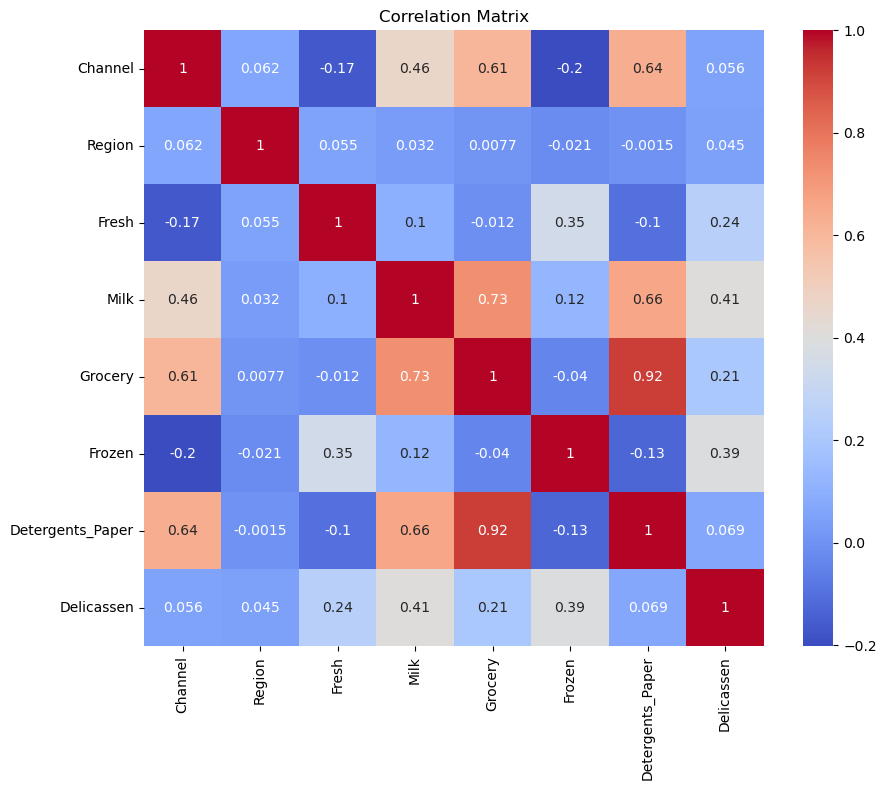

In [8]:
# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(customers.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

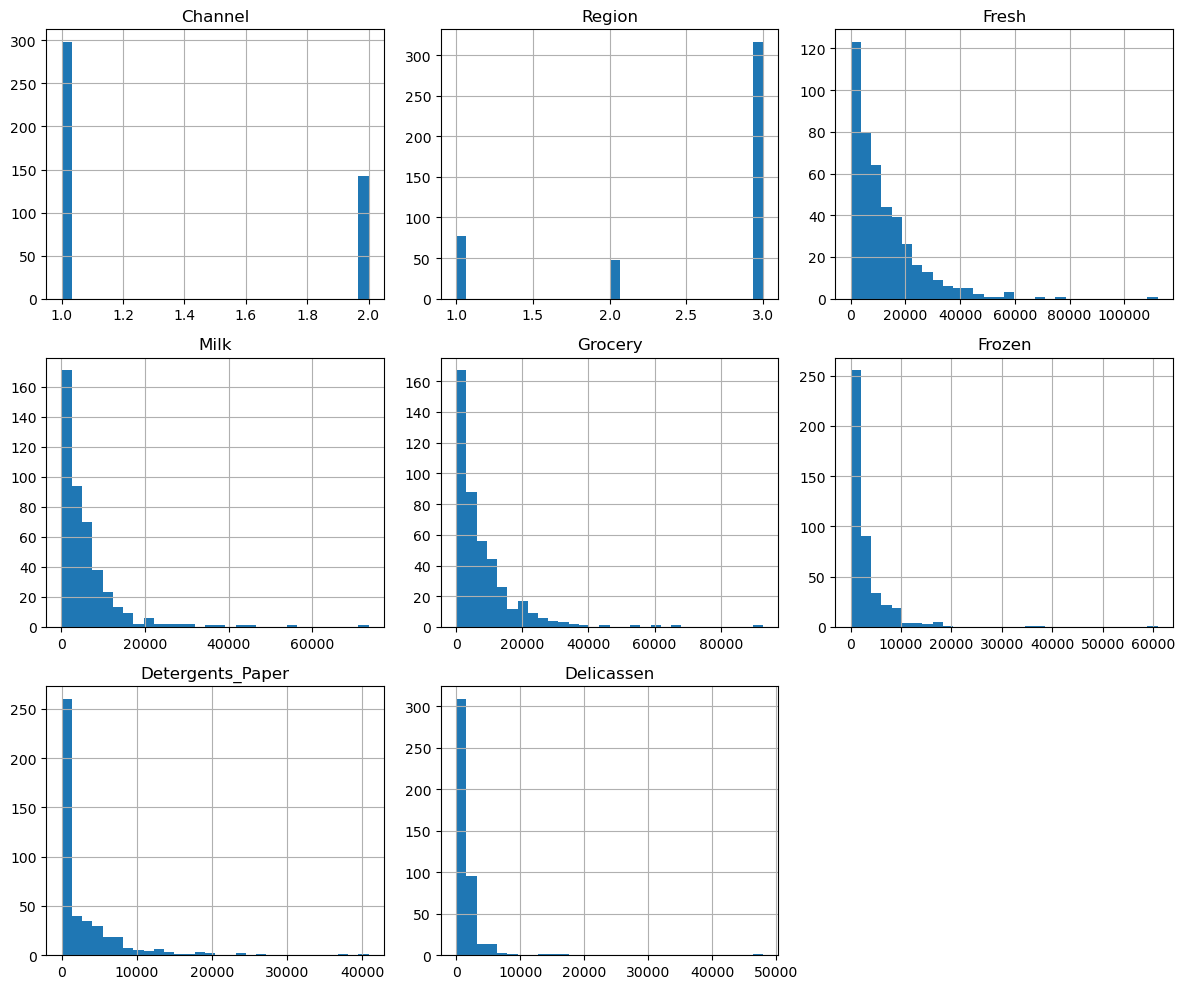

In [9]:
# Distribution of each column
customers.hist(figsize=(12,10), bins=30)
plt.tight_layout()
plt.show()

In [10]:
# Check Pareto Principle for All Spending Columns
spending_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

for col in spending_cols:
    total = customers[col].sum()
    top_20 = customers[col].sort_values(ascending=False).head(int(0.2 * len(customers))).sum()
    percent = 100 * top_20 / total
    print(f"Top 20% customers account for {percent:.2f}% of {col} sales")

Top 20% customers account for 52.67% of Fresh sales
Top 20% customers account for 56.05% of Milk sales
Top 20% customers account for 55.69% of Grocery sales
Top 20% customers account for 62.38% of Frozen sales
Top 20% customers account for 69.71% of Detergents_Paper sales
Top 20% customers account for 57.39% of Delicassen sales


In [11]:
# 1. What does each column mean?
# Channel: Type of customer (encoded as 1 or 2)
# Region: Geographic region (encoded as 1, 2, or 3)
# Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen: 
# Annual spending in each product category (numeric)

# 2. Any categorical data to convert?
# Channel and Region are categorical but currently encoded as integers. 
# They can be converted to category dtype.

# 3. Any missing data to remove?
# No missing values. All columns have 440 non-null entries.

# 4. Column collinearity - any high correlations?
# High correlation between Grocery and Detergents_Paper (0.92), and between Milk and Grocery (0.73). 
# These features may be redundant for clustering.

# 5. Descriptive statistics - any outliers to remove?
# Some columns (e.g., Fresh, Grocery, Milk, Frozen, Detegents_Paper, Delicassen) have very high maximum values compared to the median, 
# indicating outliers. Outlier removal may improve clustering results.

# 6. Column-wise data distribution - is the distribution skewed?
# All spending columns are right-skewed (long tail to the right), as shown in the histograms.
# Most customers spend relatively little, with a few spending much more.

# 7. (Other observations)
# The Pareto principle is present:
# For each spending category, the top 20% of customers account for:
# - 52.67% of Fresh sales
# - 56.05% of Milk sales
# - 55.69% of Grocery sales
# - 62.38% of Frozen sales
# - 69.71% of Detergents_Paper sales
# - 57.39% of Delicassen sales
#
# This shows that the Pareto principle (80/20 rule) is present in all categories, though not always as extreme as 80/20.
# In every case, a small group of customers is responsible for a disproportionately large share of sales.

## Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

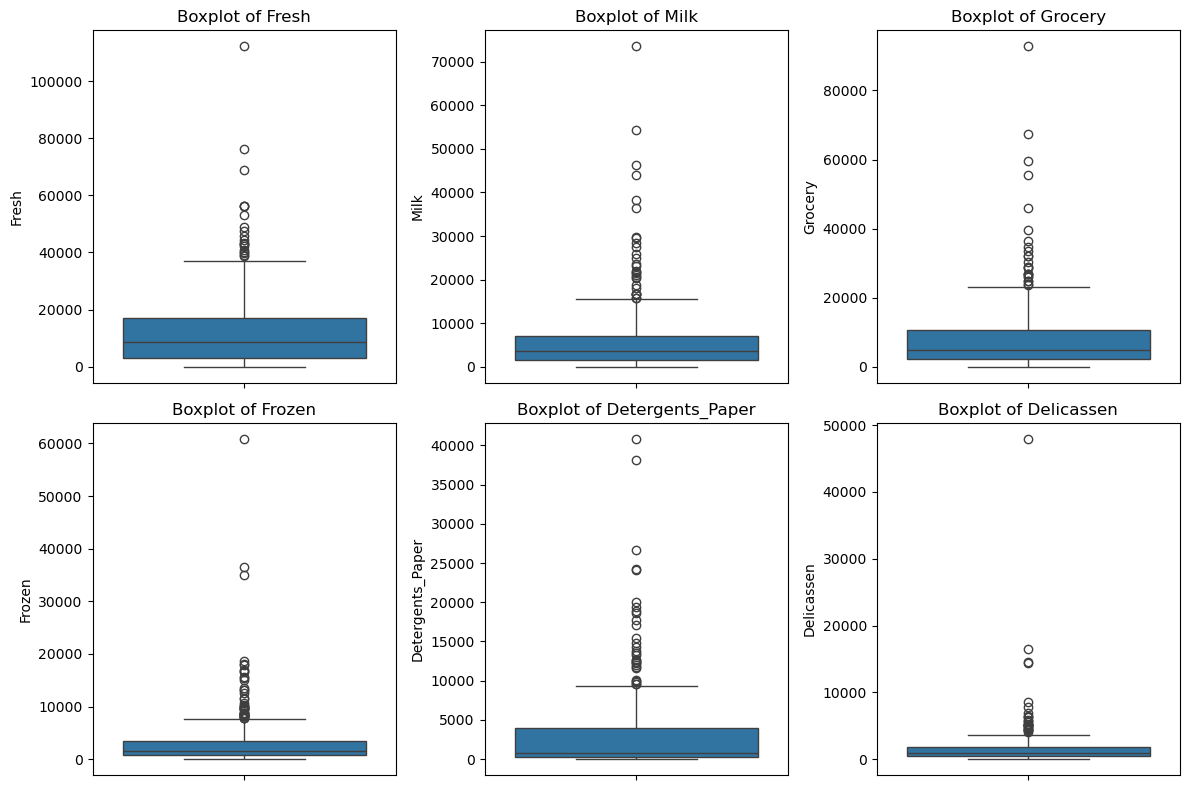

In [12]:
# Visualize outliers in each spending column using boxplots
plt.figure(figsize=(12, 8))
for i, col in enumerate(spending_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=customers[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [13]:
# Your code here
# Remove outliers using IQR for all spending columns
spending_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
filtered_customers = customers.copy()

for col in spending_cols:
    Q1 = filtered_customers[col].quantile(0.25)
    Q3 = filtered_customers[col].quantile(0.75)
    IQR = Q3 - Q1
    # Keep only rows within 1.5*IQR of Q1 and Q3
    filtered_customers = filtered_customers[
        (filtered_customers[col] >= Q1 - 1.5 * IQR) & (filtered_customers[col] <= Q3 + 1.5 * IQR)
    ]

# Convert Channel and Region to category dtype
filtered_customers['Channel'] = filtered_customers['Channel'].astype('category')
filtered_customers['Region'] = filtered_customers['Region'].astype('category')

In [14]:
# One-hot encode Channel and Region columns for clustering
filtered_customers = pd.get_dummies(filtered_customers, columns=['Channel', 'Region'], drop_first=True)

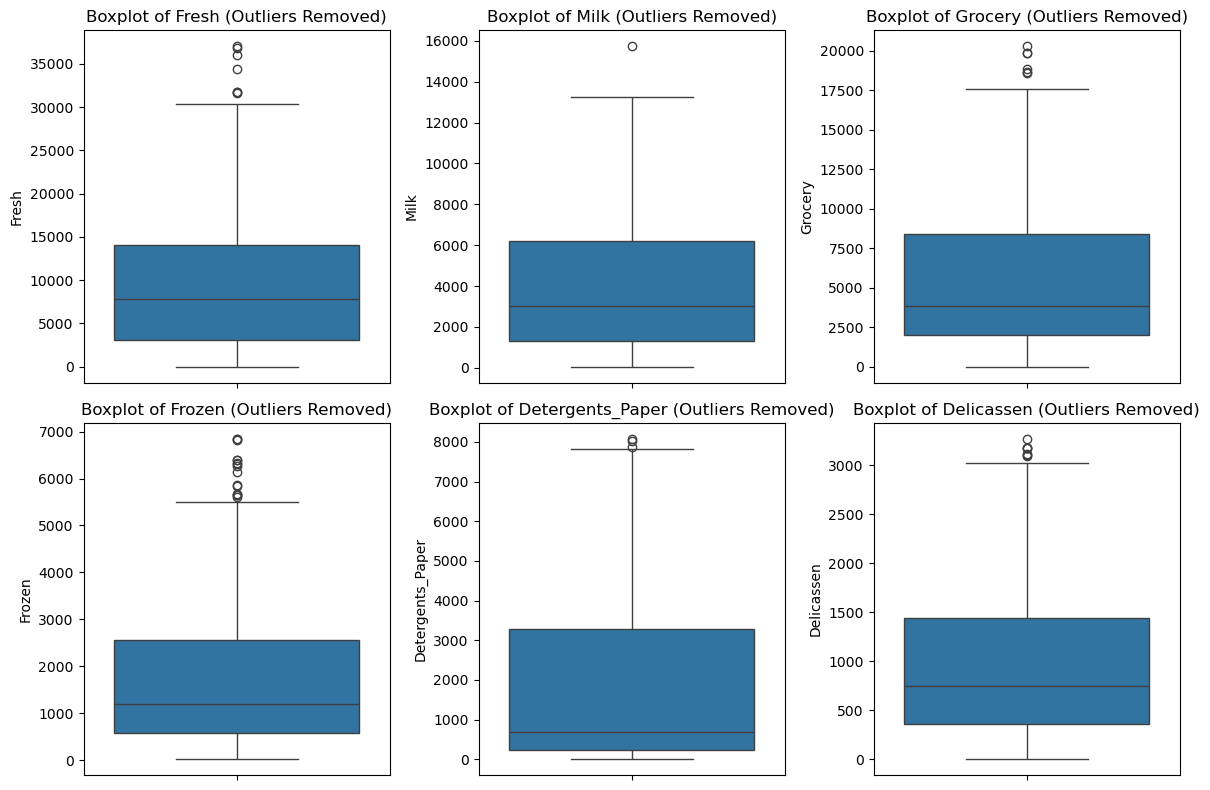

In [15]:
# Visualize outliers in each spending column after removal using boxplots
plt.figure(figsize=(12, 8))
for i, col in enumerate(spending_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=filtered_customers[col])
    plt.title(f'Boxplot of {col} (Outliers Removed)')
plt.tight_layout()
plt.show()

In [16]:
# Describe statistics after outlier removal
print(filtered_customers.describe())

              Fresh          Milk       Grocery       Frozen  \
count    318.000000    318.000000    318.000000   318.000000   
mean    9718.166667   3989.176101   5563.682390  1799.654088   
std     8200.115705   3260.597084   4623.066729  1612.664020   
min        3.000000     55.000000      3.000000    25.000000   
25%     3044.000000   1329.500000   2001.500000   575.250000   
50%     7801.500000   3045.000000   3815.500000  1194.500000   
75%    14084.750000   6188.000000   8435.500000  2559.500000   
max    37036.000000  15729.000000  20292.000000  6845.000000   

       Detergents_Paper   Delicassen  
count        318.000000   318.000000  
mean        1840.603774   984.191824  
std         2206.607239   785.423600  
min            3.000000     3.000000  
25%          228.750000   360.250000  
50%          675.000000   746.000000  
75%         3273.000000  1441.500000  
max         8077.000000  3271.000000  


In [17]:
# Removed outliers from all spending columns using the IQR method.
# No missing data to clean.
# Converted Channel and Region to category dtype for clarity, then applied one-hot encoding to these columns.
# The cleaned and encoded data is stored in filtered_customers and ready for preprocessing.
# After cleaning and encoding, the distributions and descriptive statistics are much more balanced and suitable for clustering.

In [18]:
#Check the new columns
filtered_customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_2,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,True,False,True
1,7057,9810,9568,1762,3293,1776,True,False,True
3,13265,1196,4221,6404,507,1788,False,False,True
5,9413,8259,5126,666,1795,1451,True,False,True
6,12126,3199,6975,480,3140,545,True,False,True


## Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [19]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
# Select all numeric columns for scaling and clustering
features_for_clustering = filtered_customers.select_dtypes(include=['number']).columns.tolist()

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
customers_scale = scaler.fit_transform(filtered_customers[features_for_clustering])

# Convert back to DataFrame for easier handling
customers_scale = pd.DataFrame(customers_scale, columns=features_for_clustering, index=filtered_customers.index)


## Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [20]:
# Your code here:
from sklearn.cluster import KMeans

# Initialize K-Means 
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the scaled data
kmeans.fit(customers_scale)

# Assign cluster labels to the cleaned DataFrame
filtered_customers['labels'] = kmeans.labels_

Count the values in `labels`.

In [21]:
# Your code here:
#Count values in labels
filtered_customers['labels'].value_counts()

labels
0    195
2     78
1     45
Name: count, dtype: int64

## Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [22]:
# Your code here
from sklearn.cluster import DBSCAN

# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5)

# Fit DBSCAN to the scaled data
dbscan.fit(customers_scale)

# Assign DBSCAN cluster labels to the cleaned DataFrame
filtered_customers['labels_DBSCAN'] = dbscan.labels_

Count the values in `labels_DBSCAN`.

In [23]:
# Your code here
filtered_customers['labels_DBSCAN'].value_counts()

labels_DBSCAN
-1    282
 0     23
 1     13
Name: count, dtype: int64

## Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

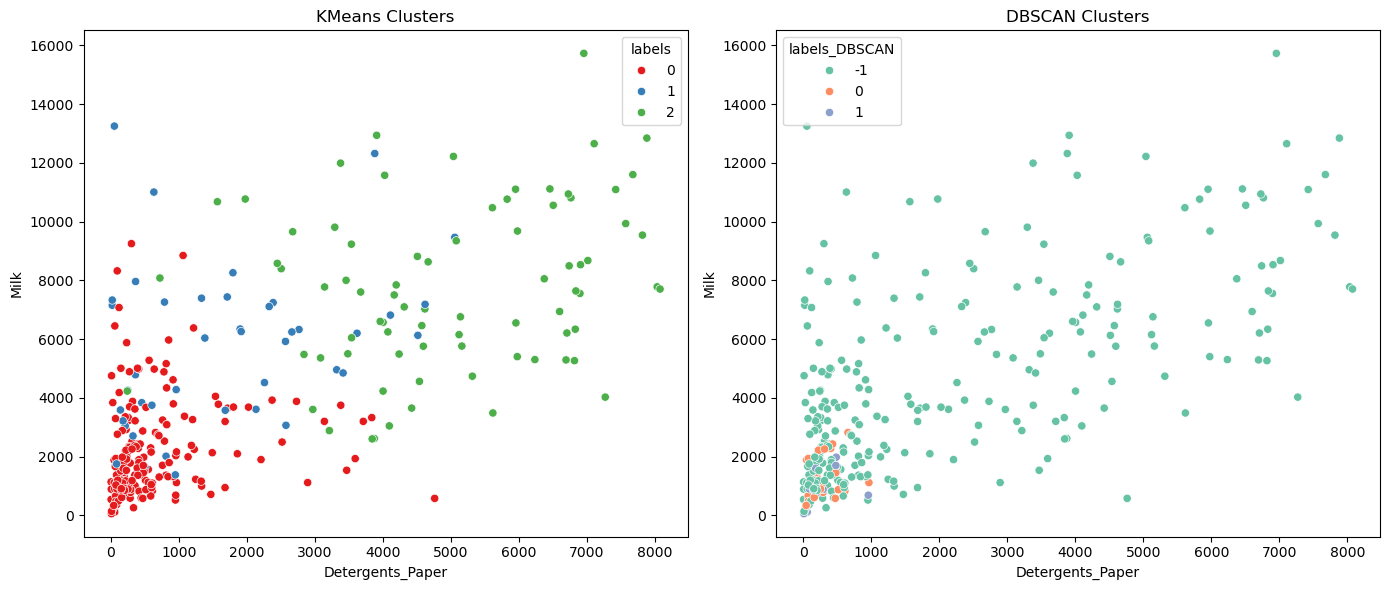

In [24]:
# Visualize Detergents_Paper vs Milk by KMeans and DBSCAN labels
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(ax=axes[0], x=filtered_customers['Detergents_Paper'], y=filtered_customers['Milk'], hue=filtered_customers['labels'], palette='Set1')
axes[0].set_title('KMeans Clusters')
sns.scatterplot(ax=axes[1], x=filtered_customers['Detergents_Paper'], y=filtered_customers['Milk'], hue=filtered_customers['labels_DBSCAN'], palette='Set2')
axes[1].set_title('DBSCAN Clusters')
plt.tight_layout()
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

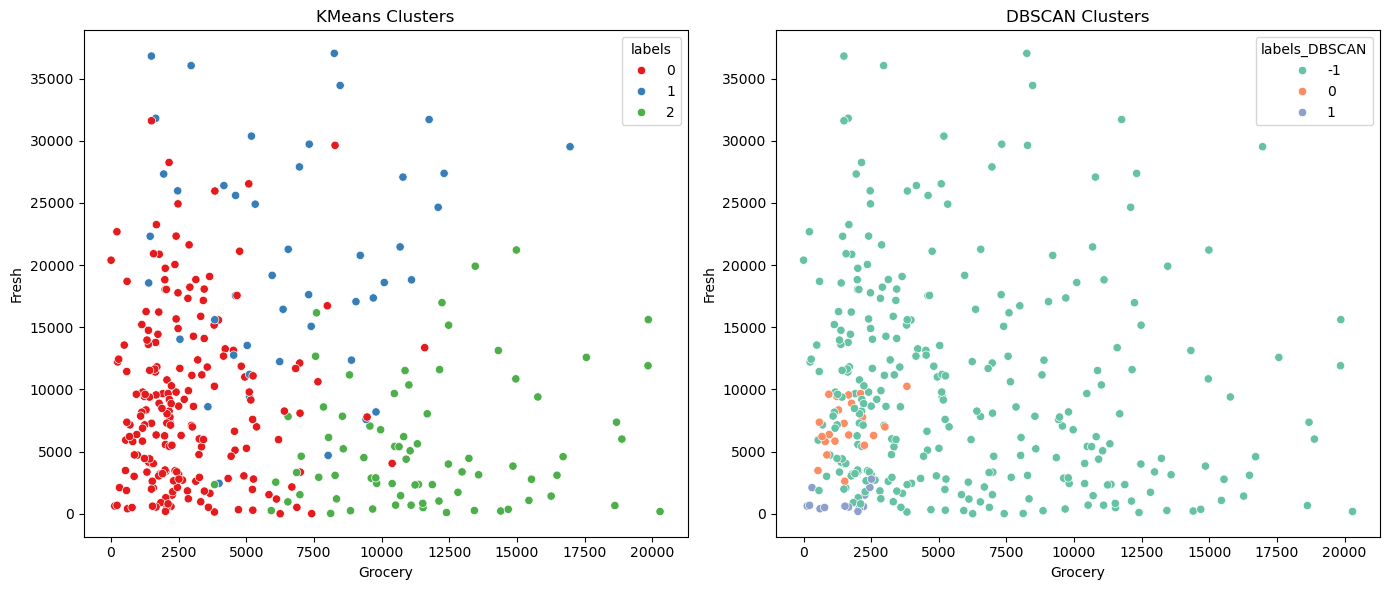

In [25]:
# Visualize Grocery vs Fresh by KMeans and DBSCAN labels
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(ax=axes[0], x=filtered_customers['Grocery'], y=filtered_customers['Fresh'], hue=filtered_customers['labels'], palette='Set1')
axes[0].set_title('KMeans Clusters')
sns.scatterplot(ax=axes[1], x=filtered_customers['Grocery'], y=filtered_customers['Fresh'], hue=filtered_customers['labels_DBSCAN'], palette='Set2')
axes[1].set_title('DBSCAN Clusters')
plt.tight_layout()
plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

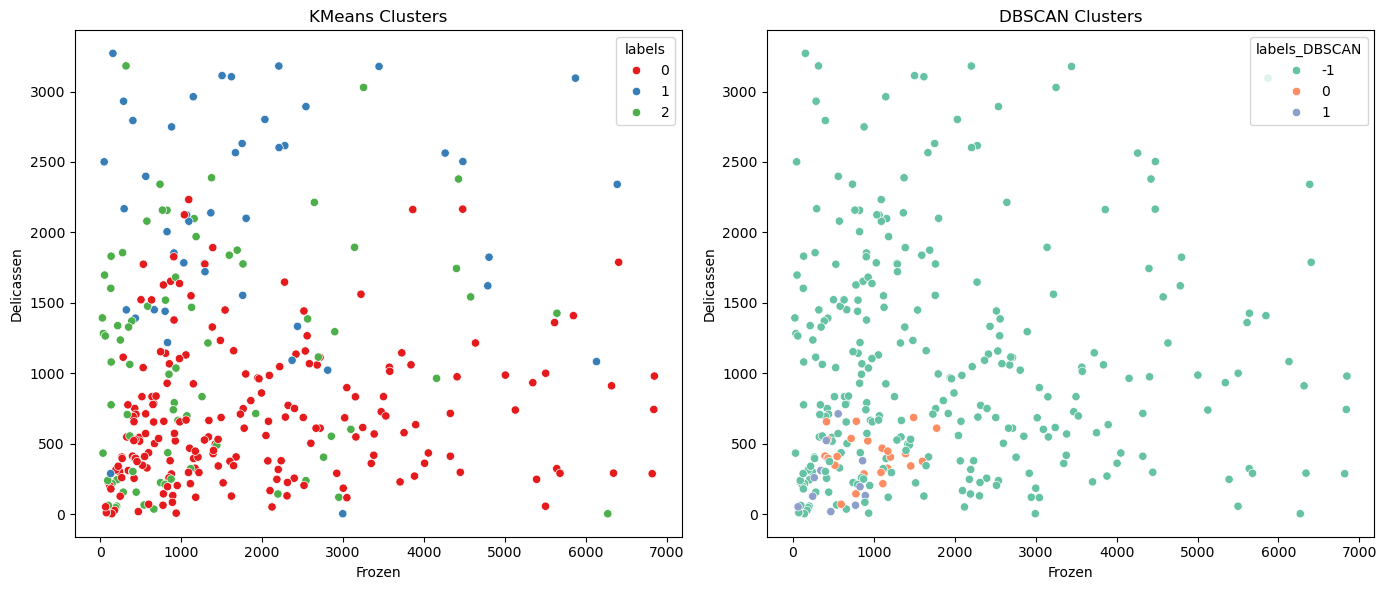

In [26]:
# Visualize Frozen vs Delicassen by KMeans and DBSCAN labels
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(ax=axes[0], x=filtered_customers['Frozen'], y=filtered_customers['Delicassen'], hue=filtered_customers['labels'], palette='Set1')
axes[0].set_title('KMeans Clusters')
sns.scatterplot(ax=axes[1], x=filtered_customers['Frozen'], y=filtered_customers['Delicassen'], hue=filtered_customers['labels_DBSCAN'], palette='Set2')
axes[1].set_title('DBSCAN Clusters')
plt.tight_layout()
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [27]:
# Group by KMeans labels and compute means (numeric columns only)
numeric_cols = filtered_customers.select_dtypes(include=['number']).columns
kmeans_means = filtered_customers.groupby('labels')[numeric_cols].mean()
print('KMeans cluster means:')
print(kmeans_means)

# Group by DBSCAN labels and compute means (numeric columns only)
dbscan_means = filtered_customers.groupby('labels_DBSCAN')[numeric_cols].mean()
print('DBSCAN cluster means:')
print(dbscan_means)

KMeans cluster means:
               Fresh         Milk       Grocery       Frozen  \
labels                                                         
0        8918.958974  2135.076923   2846.846154  1963.656410   
1       20656.311111  5471.777778   6705.155556  1954.466667   
2        5405.717949  7769.076923  11697.230769  1300.333333   

        Detergents_Paper   Delicassen  labels  labels_DBSCAN  
labels                                                        
0             625.748718   687.441026     0.0      -0.748718  
1            1604.422222  2118.200000     1.0      -1.000000  
2            5014.000000  1071.833333     2.0      -1.000000  
DBSCAN cluster means:
                      Fresh         Milk      Grocery       Frozen  \
labels_DBSCAN                                                        
-1             10335.216312  4348.946809  6071.492908  1929.301418   
 0              7076.521739  1302.652174  1666.000000   956.652174   
 1              1006.615385   938.000000

In [28]:
#  Your observations here
# KMeans assigns every customer to a cluster, providing broad segmentation. 
# The clusters are more balanced and useful for general customer grouping.
# DBSCAN finds only a few small, dense clusters and labels most customers as noise. 
# This is useful for identifying very specific customer types or outliers, but may be too strict for general segmentation.
# In this dataset, KMeans is likely more practical for customer segmentation, while DBSCAN is better for finding tight, unusual groups.

#Conclusion:
#KMeans is better for broad segmentation; 
# DBSCAN is better for finding tight clusters and outliers.
# The choice comes down to the analysis goal. 


## Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

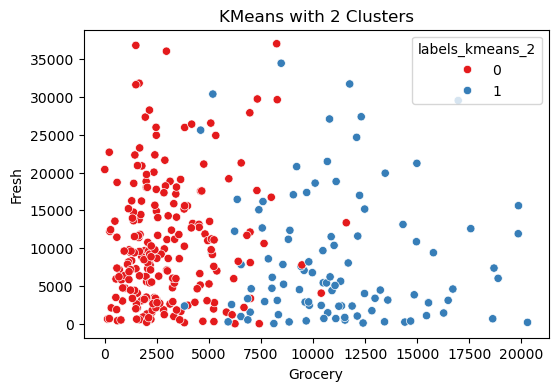

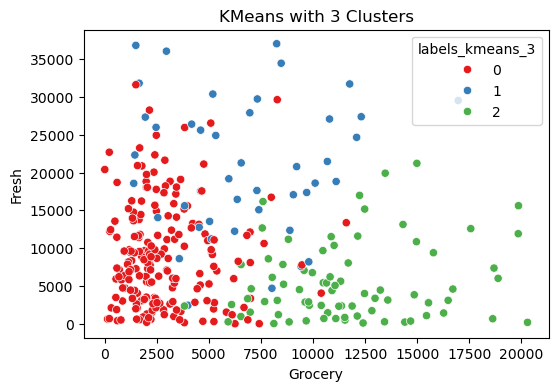

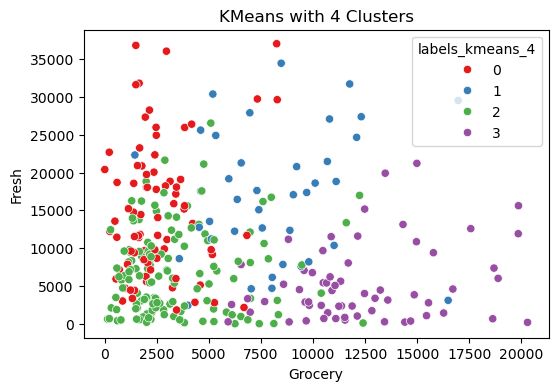

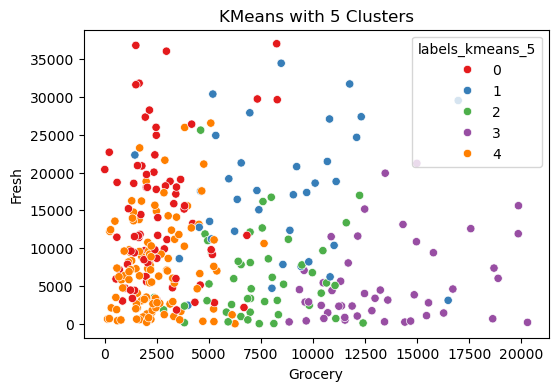

In [29]:
# Bonus Challenge 1: Try different numbers of clusters for KMeans and visualize
for n_clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customers_scale)
    filtered_customers[f'labels_kmeans_{n_clusters}'] = kmeans.labels_
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=filtered_customers['Grocery'], y=filtered_customers['Fresh'], hue=filtered_customers[f'labels_kmeans_{n_clusters}'], palette='Set1')
    plt.title(f'KMeans with {n_clusters} Clusters')
    plt.show()

In [30]:
# Based on the scatter plots above, 3 clusters provide a good balance between separation and interpretability.
# With 2 clusters, the data is split too broadly and some structure is lost.
# With 4 or 5 clusters, the groups start to overlap and become harder to interpret.
# The 3-cluster solution reveals distinct customer segments with different spending patterns.
#  Visually, 3 clusters work best for this dataset.

In [31]:
# For each KMean analysis
# 2 Clusters:
# The data is split into two broad groups, but there is significant overlap and some structure is lost. It’s a coarse separation.

# 3 Clusters:
# The clusters are more distinct. You can see a group with high Grocery, a group with high Fresh, and a group with lower values. 
# This separation looks meaningful and interpretable.

# 4 Clusters:
# The data is split further, but some clusters start to overlap and may not be as distinct. There is more granularity, but it’s harder to interpret.

# 5 Clusters:
# The plot shows even more clusters, but some are very close together and the separation is less clear. It may be over-segmenting the data.

## Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

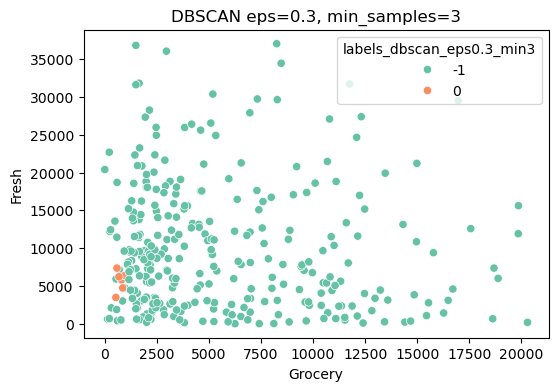

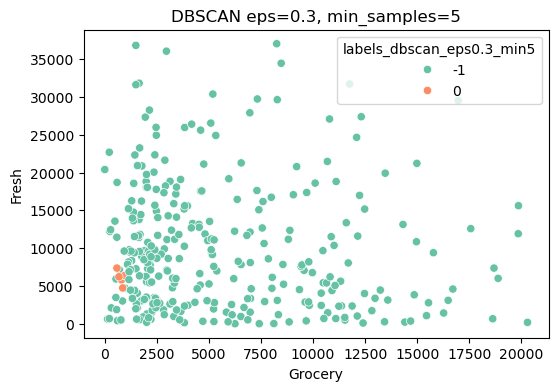

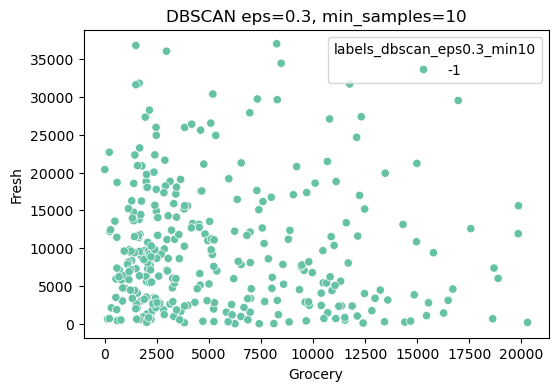

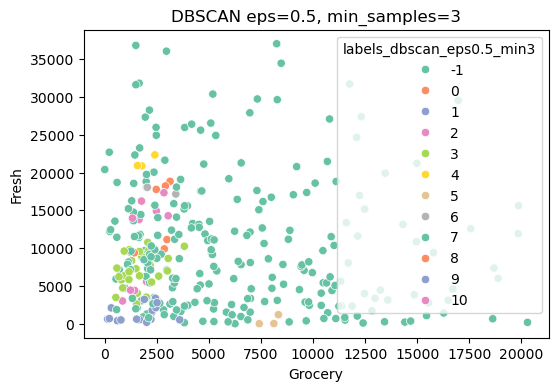

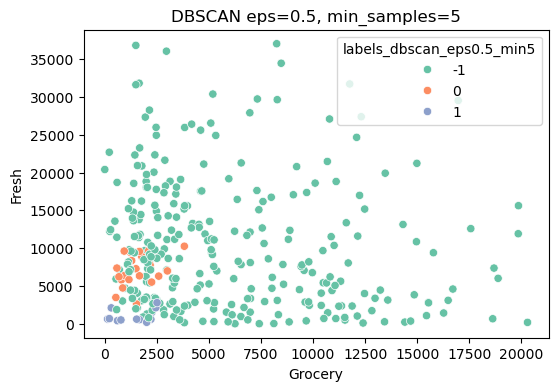

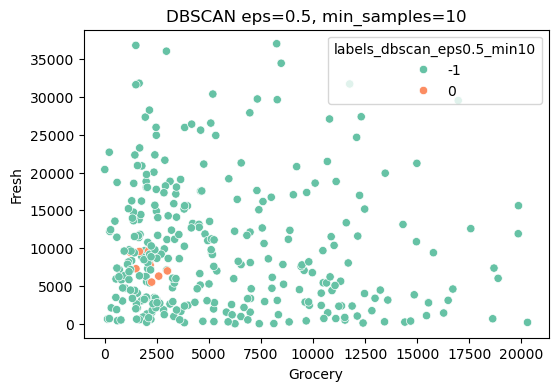

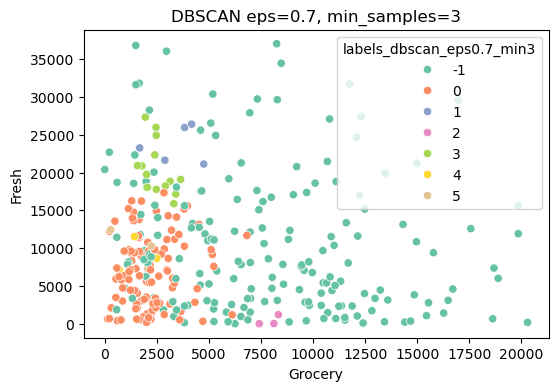

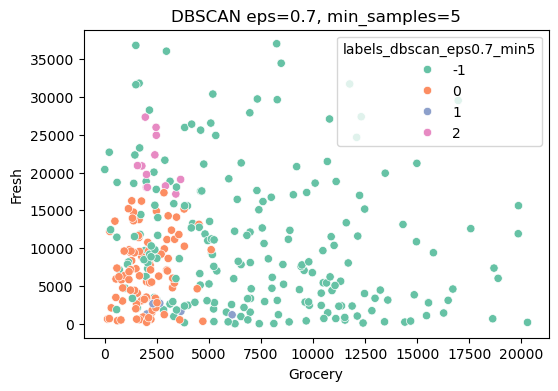

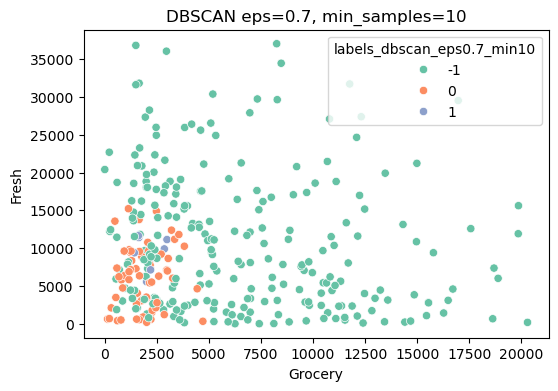

In [32]:
# Bonus Challenge 2: Try different eps and min_samples for DBSCAN and visualize
for eps in [0.3, 0.5, 0.7]:
    for min_samples in [3, 5, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(customers_scale)
        filtered_customers[f'labels_dbscan_eps{eps}_min{min_samples}'] = dbscan.labels_
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=filtered_customers['Grocery'], y=filtered_customers['Fresh'], hue=filtered_customers[f'labels_dbscan_eps{eps}_min{min_samples}'], palette='Set2')
        plt.title(f'DBSCAN eps={eps}, min_samples={min_samples}')
        plt.show()

In [33]:
# After evaluating all combinations of eps and min_samples for DBSCAN, the best clustering results are with eps=0.7 and min_samples=3 or 5.
# These settings reveal several distinct clusters with less noise, making them the most interpretable for this dataset.
# Lower eps or higher min_samples result in too much noise or very few clusters, while moderate values provide a better balance 
# -between cluster size and separation.


In [34]:
# #For detailed analysis 
# eps=0.3
# min_samples=3, 5, 10: Almost all points are labeled as noise (-1), with only a tiny cluster (if any).
# This setting is too strict and does not reveal meaningful clusters.

# eps=0.5
# min_samples=3: Many small clusters are formed, but most are not well separated and may not be meaningful. Some points are still labeled as noise.
# min_samples=5: Only a few clusters are found, with more points labeled as noise. Clusters are small and not very distinct.
# min_samples=10: Only one small cluster is found, most points are noise. Too strict.

# eps=0.7
# min_samples=3: Several clusters are formed, with fewer points labeled as noise. Clusters are more visible, but some overlap.
# min_samples=5: A few clusters are found, with moderate noise. Clusters are somewhat distinct.
# min_samples=10: Only two clusters and some noise. Clusters are small and not well separated.